# Imports e Configurações

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import _pickle as pkl
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn import preprocessing

%matplotlib inline

# Funções de Ativação

In [2]:
def linear(x, derivative=False):
    return np.ones_like(x) if derivative else x

def sigmoid(x, derivative=False):
    if derivative:
        y = sigmoid(x)
        return y*(1 - y)
    return 1.0/(1.0 + np.exp(-x))

def tanh(x, derivative=False):
    if derivative:
        y = tanh(x)
        return 1 - y**2
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0, 1)
    return np.maximum(0, x)

def leaky_relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0.1, 1)
    return np.where(x < 0, 0.1*x, x)

def gaussian(x, derivative=False):
    if derivative:
        return -2*x*np.exp(-x**2)
    return np.exp(-x**2)

# Funções Auxiliares

In [3]:
def softmax(x, y_oh=None, derivative=False):
    if derivative: 
        y_pred = softmax(x)
        y_correct = np.argmax(y_oh, axis=1)
        pk = y_pred[range(y_pred.shape[0]), y_correct]
        y_pred[range(y_pred.shape[0]), y_correct] = pk*(1.0 - pk)
        return y_pred
    exp = np.exp(x)
    return exp/np.sum(exp, axis=1, keepdims=True)

def neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_correct = np.argmax(y_oh, axis=1)
    pk = y_pred[range(y_pred.shape[0]), y_correct]
    if derivative:
        y_pred[range(y_pred.shape[0]), y_correct] = (-1.0/pk)
        return y_pred
    return np.mean(-np.log(pk))

# Funções de Custo

###### Para Regressão

In [4]:
def mae(y, y_pred, derivative=False):
    if derivative:
        return np.where(y_pred > y, 1, -1) / y.shape[0]
    return np.mean(np.abs(y-y_pred))
def mse(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred)/y.shape[0]
    return 0.5 * np.mean((y - y_pred)**2)

###### Para Classificação Binária

In [5]:
def binary_cross_entropy(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred) / (y_pred * (1-y_pred) * y.shape[0])
    return -np.mean(y*np.log(y_pred) + (1-y)*np.log(1-y_pred))

def sigmoid_cross_entropy(y, y_pred, derivative=False):
    y_sigmoid = sigmoid(y_pred)
    if derivative:
        return -(y - y_sigmoid) / y.shape[0]
    return -np.mean(y*np.log(y_sigmoid) + (1-y)*np.log(1-y_sigmoid))

###### Para Classificação Multiclasse

In [6]:
def softmax_neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_softmax = softmax(y_pred)
    y_correct = np.argmax(y_oh, axis=1)
    pk = y_softmax[range(y_softmax.shape[0]), y_correct]
    if derivative:
        return -(y_oh - y_softmax)/y_oh.shape[0]
    return np.mean(-np.log(pk))

# Inicialização de Pesos

In [7]:
def zeros(rows, cols):
    return np.zeros((rows, cols))

def ones(rows, cols):
    return np.ones((rows, cols))

def random_normal(rows, cols):
    return np.random.randn(rows, cols)

def random_uniform(rows, cols):
    return np.random.rand(rows, cols)

def glorot_normal(rows, cols):
    # normal com média 0 e stddev=sqrt(2.0/(out+inp))
    std_dev = np.sqrt(2.0 / (rows + cols))
    return std_dev * np.random.randn(rows, cols)

def glorot_uniform(rows, cols):
    # uniforme de [-limit, limit], limit = np.sqrt(6.0 / (out + inp))
    limit = np.sqrt(6.0 / (rows + cols))
    return 2*limit*np.random.rand(rows, cols) - limit

# Regularização

###### Dos Pesos

In [8]:
def l1_regularization(weights, derivative=False):
    if derivative:
        weights = [np.where(w < 0, -1, w) for w in weights]
        return np.array([np.where(w >0, 1, w) for w in weights])
    return np.sum([np.sum(np.abs(w)) for w in weights])

def l2_regularization(weights, derivative=False):
    if derivative:
        return weights
    return 0.5 * np.sum(weights**2)

# Batch Generator

In [9]:
def batch_sequential(x, y, batch_size=None):
    batch_size = x.shape[0] if batch_size is None else batch_size
    n_batches = x.shape[0] // batch_size
    
    for batch in range(n_batches):
        offset = batch_size * batch
        x_batch, y_batch = x[offset:offset+batch_size], y[offset:offset+batch_size]
        yield (x_batch, y_batch)
    
def batch_shuffle(x, y, batch_size=None):
    shuffle_index = np.random.permutation(range(x.shape[0]))
    return batch_sequential(x[shuffle_index], y[shuffle_index], batch_size)

# Learning Rate Decay

In [10]:
def none_decay(learning_rate, epoch, decay_rate, decay_step=1):
    return learning_rate

def time_based_decay(learning_rate, epoch, decay_rate, decay_steps=1):
    return 1.0 / (1 + decay_rate * epoch)

def exponential_decay(learning_rate, epoch, decay_rate, decay_steps=1):
    return learning_rate * decay_rate**epoch

def staircase_decay(learning_rate, epoch, decay_rate, decay_steps=1):
    return learning_rate * decay_rate**(epoch // decay_steps)

# Batch Normalization

In [11]:
def batchnorm_forward(layer, x, is_training=True):
    mu = np.mean(x, axis=0) if is_training else layer._pop_mean
    var = np.var(x, axis=0) if is_training else layer._pop_var
    x_norm = (x - mu) / np.sqrt(var + 1e-8)
    out = layer.gamma * x_norm + layer.beta

    if is_training:
        layer._pop_mean = layer.bn_decay * layer._pop_mean + (1.0-layer.bn_decay)*mu
        layer._pop_var = layer.bn_decay * layer._pop_var + (1.0-layer.bn_decay)*var
        layer._bn_cache = (x, x_norm, mu, var)
    return out

def batchnorm_backward(layer, dactivation):
    x, x_norm, mu, var = layer._bn_cache

    m = layer._activ_inp.shape[0]
    x_mu = x - mu
    std_inv = 1.0 / np.sqrt(var + 1e-8)

    dx_norm = dactivation * layer.gamma
    dvar = np.sum(dx_norm * x_mu, axis=0) * -0.5 * (std_inv**3)
    dmu = np.sum(dx_norm * -std_inv, axis=0) + dvar * np.mean(-2.0 * x_mu, axis=0)

    dx = (dx_norm * std_inv) + (dvar * 2.0 * x_mu / m) + (dmu / m)
    layer._dgamma = np.sum(dactivation * x_norm, axis=0)
    layer._dbeta = np.sum(dactivation, axis=0)
    return dx

# Implementação 

In [12]:
class Layer():
    def __init__(self, input_dim, output_dim, activation=linear, weights_initializer=random_normal, biases_initializer=ones, 
                 dropout_prob=0.0, reg_func=l2_regularization, reg_strength=0.0, batch_norm=False, bn_decay=0.9, 
                 is_trainable=True):
        self.input = None
        self.weights = weights_initializer(output_dim, input_dim)
        self.biases = biases_initializer(1, output_dim)
        self.activation = activation
        self.dropout_prob = dropout_prob
        self.reg_func = reg_func
        self.reg_strength = reg_strength
        self.batch_norm = batch_norm
        self.bn_decay = bn_decay
        self.gamma, self.beta = ones(1, output_dim), zeros(1, output_dim)
        self.is_trainable = is_trainable

        self._activ_inp, self._activ_out = None, None
        self._dweights, self._dbiases, self._prev_dweights = None, None, 0.0
        self._dropout_mask = None
        self._dgamma, self._dbeta = None, None
        self._pop_mean, self._pop_var = zeros(1, output_dim), zeros(1, output_dim)
        self._bn_cache = None

class NeuralNetwork():
    def __init__(self, cost_func=mse, learning_rate=1e-3, lr_decay_method=none_decay, lr_decay_rate=0.0, lr_decay_steps=1, 
                 momentum=0.0, patience=np.inf):
        self.layers = []
        self.cost_func = cost_func
        self.learning_rate = self.lr_initial = learning_rate
        self.lr_decay_method = lr_decay_method
        self.lr_decay_rate = lr_decay_rate
        self.lr_decay_steps = lr_decay_steps
        self.momentum = momentum
        self.patience, self.waiting = patience, 0
        self._best_model, self._best_loss = self.layers, np.inf
        
    def fit(self, x_train, y_train, x_val=None, y_val=None, epochs=100, verbose=10, batch_gen=batch_sequential, 
            batch_size=None):
        x_val, y_val = (x_train, y_train) if (x_val is None or y_val is None) else (x_val, y_val)
        costs = []
        for epoch in range(epochs+1):
            self.learning_rate = self.lr_decay_method(self.lr_initial, epoch, self.lr_decay_rate, self.lr_decay_steps)
            
            for x_batch, y_batch in batch_gen(x_train, y_train, batch_size):
                y_pred = self.__feedforward(x_batch)
                self.__backprop(y_batch, y_pred)
                
                loss_val = self.cost_func(y_val, self.predict(x_val))
                if loss_val < self._best_loss:
                    self._best_model, self._best_loss = self.layers, loss_val
                    self.waiting = 0
                else:
                    self.waiting += 1
                    if self.waiting >= self.patience:
                        self.layers = self._best_model
                        return
            loss_train = self.cost_func(y_train, self.predict(x_train))
            costs.append(loss_train)        
            if epoch % verbose == 0:
                loss_reg = (1.0/y_train.shape[0])*np.sum([layer.reg_strength * layer.reg_func(layer.weights) for layer in 
                self.layers])
                print("epoch: {0:=4}/{1} loss_train: {2:.8f} + {3:.8f} = {4:.8f} loss_val: {5:.8f}".format(epoch, epochs, 
                loss_train, loss_reg, loss_train + loss_reg, loss_val))
                
        plt.plot(np.squeeze(costs), color="orange", label="train")
        plt.ylabel('loss')
        plt.xlabel('iterations')
        plt.title("Learning rate =" + str(self.learning_rate))
        plt.show()
        
    def predict(self, x):
        return self.__feedforward(x, is_training=False)
    
    def __feedforward(self, x, is_training=True):
        self.layers[0].input = x
        for current_layer, next_layer in zip(self.layers, self.layers[1:] + [Layer(0, 0)]):
            y = np.dot(current_layer.input, current_layer.weights.T) + current_layer.biases
            y = batchnorm_forward(current_layer, y, is_training) if current_layer.batch_norm else y
            current_layer._dropout_mask = np.random.binomial(1, 1.0-current_layer.dropout_prob, y.shape) / (1.0 - 
            current_layer.dropout_prob)
            current_layer._activ_inp = y
            current_layer._activ_out = current_layer.activation(y) * (current_layer._dropout_mask if is_training else 1.0)
            next_layer.input = current_layer._activ_out
        return self.layers[-1]._activ_out
    
    def __backprop(self, y, y_pred):
        last_delta = self.cost_func(y, y_pred, derivative=True)
        for layer in reversed(self.layers):
            dactivation = layer.activation(layer._activ_inp, derivative=True) * last_delta * layer._dropout_mask
            dactivation = batchnorm_backward(layer, dactivation) if layer.batch_norm else dactivation
            last_delta = np.dot(dactivation, layer.weights)
            layer._dweights = np.dot(dactivation.T, layer.input)
            layer._dbiases = 1.0*dactivation.sum(axis=0, keepdims=True)
        
        for layer in reversed(self.layers):
            if layer.is_trainable:
                layer._dweights = layer._dweights + (1.0/y.shape[0]) * layer.reg_strength * layer.reg_func(layer.weights, 
                derivative=True)
                layer._prev_dweights = -self.learning_rate*layer._dweights + self.momentum*layer._prev_dweights
                layer.weights = layer.weights + layer._prev_dweights
                layer.biases = layer.biases - self.learning_rate*layer._dbiases
                if layer.batch_norm:
                    layer.gamma = layer.gamma - self.learning_rate*layer._dgamma
                    layer.beta = layer.beta - self.learning_rate*layer._dbeta

# 1A LISTA DE EXERCÍCIOS

# 1)

In [13]:
x_train = pd.read_csv('data/1/dataset1.csv', header=None)
y_train = pd.read_csv('data/1/dataset2.csv', header=None)
x_train, y_train = shuffle(np.array(x_train), np.array(y_train))

In [14]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y_train)

In [15]:
x_test = pd.read_csv('data/1/dataset3.csv', header=None)
y_test = pd.read_csv('data/1/dataset4.csv', header=None)
x_test, y_test = shuffle(np.array(x_test), np.array(y_test))

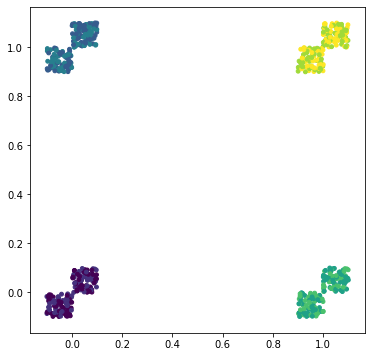

In [16]:
plt.figure(figsize=(6, 6))
plt.scatter(x_train[:,0], x_train[:,1], c=list(np.array(y_train).ravel()), s=15, cmap=plt.cm.viridis)

epoch:    0/300 loss_train: 3.16607955 + 0.00000000 = 3.16607955 loss_val: 3.16607955
epoch:   50/300 loss_train: 0.08613454 + 0.00000000 = 0.08613454 loss_val: 0.08613454
epoch:  100/300 loss_train: 0.03041508 + 0.00000000 = 0.03041508 loss_val: 0.03041508
epoch:  150/300 loss_train: 0.01735185 + 0.00000000 = 0.01735185 loss_val: 0.01735185
epoch:  200/300 loss_train: 0.01185058 + 0.00000000 = 0.01185058 loss_val: 0.01185058
epoch:  250/300 loss_train: 0.00888796 + 0.00000000 = 0.00888796 loss_val: 0.00888796
epoch:  300/300 loss_train: 0.00705719 + 0.00000000 = 0.00705719 loss_val: 0.00705719


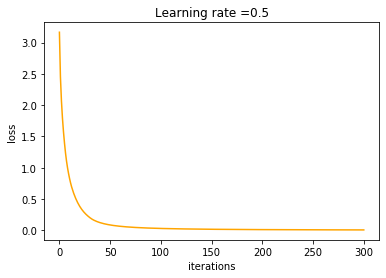

Accuracy: 100.00%


In [17]:
D_in, D_out = x_train.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=0.5)
nn.layers.append(Layer(input_dim=D_in, output_dim=8, activation=relu))
nn.layers.append(Layer(input_dim=8, output_dim=D_out, activation=linear))

nn.fit(x_train, y_onehot, epochs=300, verbose=50)

y_pred = np.argmax(nn.predict(x_test), axis=1)
print('Accuracy: {:.2f}%'.format(100*accuracy_score(y_test, y_pred+1)))

# 2)

## a)

In [18]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0]).reshape(-1, 1)

epoch:    0/200 loss_train: 2.13436677 + 0.00000000 = 2.13436677 loss_val: 2.13436677
epoch:   50/200 loss_train: 0.03876778 + 0.00000000 = 0.03876778 loss_val: 0.03876778
epoch:  100/200 loss_train: 0.01281271 + 0.00000000 = 0.01281271 loss_val: 0.01281271
epoch:  150/200 loss_train: 0.00711278 + 0.00000000 = 0.00711278 loss_val: 0.00711278
epoch:  200/200 loss_train: 0.00477477 + 0.00000000 = 0.00477477 loss_val: 0.00477477


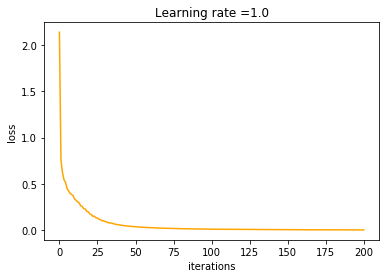

Accuracy: 100.00%


In [19]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1.0)
nn.layers.append(Layer(input_dim=D_in, output_dim=8, activation=relu))
nn.layers.append(Layer(input_dim=8, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=200, verbose=50)

y_pred = nn.predict(x)
print('Accuracy: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

## b)

In [20]:
x_train = pd.read_csv('data/2/dataset1.csv', header=None)
y_train = pd.read_csv('data/2/dataset2.csv', header=None)
x_test = pd.read_csv('data/2/dataset3.csv', header=None)
y_test = pd.read_csv('data/2/dataset4.csv', header=None)
x_train = x_train.to_numpy()
y_train = y_train.to_numpy()
x_test = x_test.to_numpy()
y_test = y_test.to_numpy()

epoch:    0/2000 loss_train: 0.40228003 + 0.00000000 = 0.40228003 loss_val: 0.40228003
epoch:  500/2000 loss_train: 0.00052171 + 0.00000000 = 0.00052171 loss_val: 0.00052171
epoch: 1000/2000 loss_train: 0.00039524 + 0.00000000 = 0.00039524 loss_val: 0.00039524
epoch: 1500/2000 loss_train: 0.00033516 + 0.00000000 = 0.00033516 loss_val: 0.00033516
epoch: 2000/2000 loss_train: 0.00029099 + 0.00000000 = 0.00029099 loss_val: 0.00029099


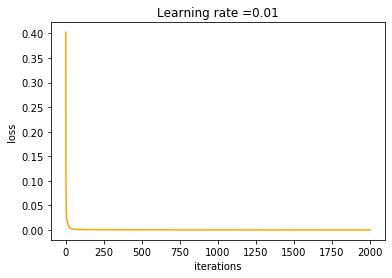

In [21]:
D_in, D_out = x_train.shape[1], y_train.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-2, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=12, activation=tanh, weights_initializer=glorot_normal))
nn.layers.append(Layer(input_dim=12, output_dim=12, activation=tanh, weights_initializer=glorot_normal))
nn.layers.append(Layer(input_dim=12, output_dim=D_out, activation=linear))

nn.fit(x_train, y_train, batch_size=20, epochs=2000, verbose=500)

Mean squared error: 17.96%


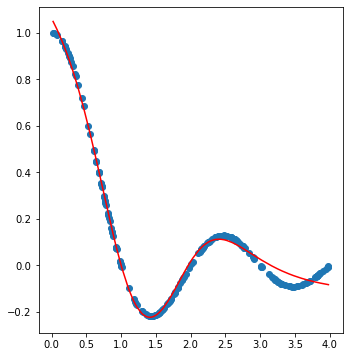

In [22]:
sorted_x_train = np.sort(x_train, axis=0)
y_pred = nn.predict(sorted_x_train)
print('Mean squared error: {:.2f}%'.format(100*mean_squared_error(y_train, y_pred)))
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x_train, y_train)
plt.plot(sorted_x_train, y_pred, color = 'red')

Mean squared error: 15.27%


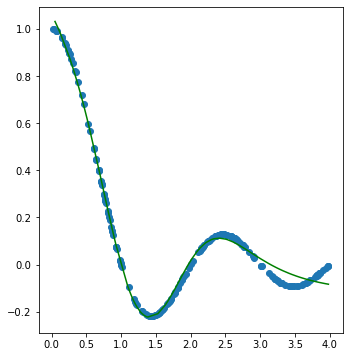

In [23]:
sorted_x_test = np.sort(x_test, axis=0)
y_pred = nn.predict(sorted_x_test)
print('Mean squared error: {:.2f}%'.format(100*mean_squared_error(y_test, y_pred)))
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x_train, y_train)
plt.plot(sorted_x_test, y_pred, color = 'green')

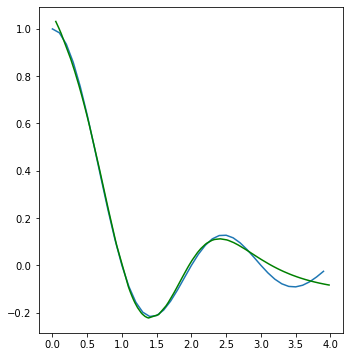

In [24]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
x = np.arange(0.0001, 4, 0.1)
y = np.sin(np.pi*x)/(np.pi*x)
plt.plot(x, y)
plt.plot(sorted_x_test, y_pred, color = 'green')

# 3)

In [25]:
x_train = pd.read_csv('data/3/dataset1.csv', header=None)
y_train = pd.read_csv('data/3/dataset2.csv', header=None)
x_test = pd.read_csv('data/3/dataset3.csv', header=None)
y_test = pd.read_csv('data/3/dataset4.csv', header=None)
x_train = x_train.to_numpy()
y_train = y_train.to_numpy()
x_test = x_test.to_numpy()
y_test = y_test.to_numpy()

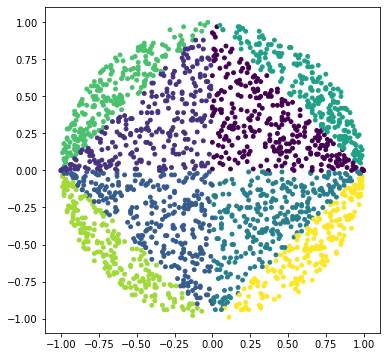

In [26]:
plt.figure(figsize=(6, 6))
plt.scatter(x_train[:,0], x_train[:,1], c=list(np.array(y_train).ravel()), s=15, cmap=plt.cm.viridis)

In [27]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y_train)

epoch:    0/2000 loss_train: 3.62043318 + 0.00000000 = 3.62043318 loss_val: 3.62043318
epoch:  100/2000 loss_train: 0.48765970 + 0.00000000 = 0.48765970 loss_val: 0.48765970
epoch:  200/2000 loss_train: 0.32751389 + 0.00000000 = 0.32751389 loss_val: 0.32751389
epoch:  300/2000 loss_train: 0.25509933 + 0.00000000 = 0.25509933 loss_val: 0.25509933
epoch:  400/2000 loss_train: 0.21408996 + 0.00000000 = 0.21408996 loss_val: 0.21408996
epoch:  500/2000 loss_train: 0.18744738 + 0.00000000 = 0.18744738 loss_val: 0.18744738
epoch:  600/2000 loss_train: 0.16822380 + 0.00000000 = 0.16822380 loss_val: 0.16822380
epoch:  700/2000 loss_train: 0.15337009 + 0.00000000 = 0.15337009 loss_val: 0.15337009
epoch:  800/2000 loss_train: 0.14192698 + 0.00000000 = 0.14192698 loss_val: 0.14192698
epoch:  900/2000 loss_train: 0.13264013 + 0.00000000 = 0.13264013 loss_val: 0.13264013
epoch: 1000/2000 loss_train: 0.12491720 + 0.00000000 = 0.12491720 loss_val: 0.12491720
epoch: 1100/2000 loss_train: 0.11837492 + 0

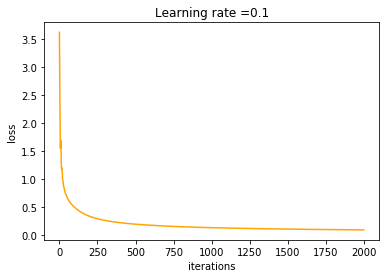

Accuracy: 98.60%


In [28]:
D_in, D_out = x_train.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=8, activation=relu))
nn.layers.append(Layer(input_dim=8, output_dim=D_out, activation=linear))

nn.fit(x_train, y_onehot, epochs=2000, verbose=100)

y_pred = np.argmax(nn.predict(x_test), axis=1)
print('Accuracy: {:.2f}%'.format(100*accuracy_score(y_test, y_pred)))

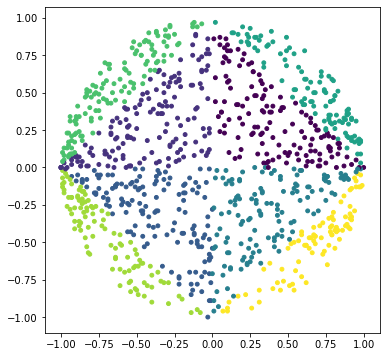

In [29]:
plt.figure(figsize=(6, 6))
plt.scatter(x_test[:,0], x_test[:,1], c=list(np.array(y_pred).ravel()), s=15, cmap=plt.cm.viridis)

In [30]:
print(metrics.confusion_matrix(y_test, y_pred))

[[138   0   0   2   3   0   0   0]
 [  0 153   0   0   0   0   0   0]
 [  0   1 142   1   0   0   2   0]
 [  0   0   0 131   0   0   0   1]
 [  1   0   0   0 107   0   0   0]
 [  0   2   0   0   0 126   0   0]
 [  0   0   1   0   0   0 102   0]
 [  0   0   0   0   0   0   0  87]]


In [31]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       143
           1       0.98      1.00      0.99       153
           2       0.99      0.97      0.98       146
           3       0.98      0.99      0.98       132
           4       0.97      0.99      0.98       108
           5       1.00      0.98      0.99       128
           6       0.98      0.99      0.99       103
           7       0.99      1.00      0.99        87

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



# 4)

In [85]:
x_train = pd.read_csv('data/4/dataset1.csv', header=None)
y_train = pd.read_csv('data/4/dataset2.csv', header=None)
x_test = pd.read_csv('data/4/dataset3.csv', header=None)
y_test = pd.read_csv('data/4/dataset4.csv', header=None)
xplot = pd.read_csv('data/4/dataset5.csv', header=None)
x_train = x_train.to_numpy()
y_train = y_train.to_numpy()
x_test = x_test.to_numpy()
y_test = y_test.to_numpy()
xplot = xplot.to_numpy()

epoch:    0/2000 loss_train: 0.79386213 + 0.00000000 = 0.79386213 loss_val: 0.79386213
epoch:  100/2000 loss_train: 0.01878021 + 0.00000000 = 0.01878021 loss_val: 0.01878021
epoch:  200/2000 loss_train: 0.01297211 + 0.00000000 = 0.01297211 loss_val: 0.01297211
epoch:  300/2000 loss_train: 0.00972297 + 0.00000000 = 0.00972297 loss_val: 0.00972297
epoch:  400/2000 loss_train: 0.00757840 + 0.00000000 = 0.00757840 loss_val: 0.00757840
epoch:  500/2000 loss_train: 0.00609033 + 0.00000000 = 0.00609033 loss_val: 0.00609033
epoch:  600/2000 loss_train: 0.00502880 + 0.00000000 = 0.00502880 loss_val: 0.00502880
epoch:  700/2000 loss_train: 0.00427050 + 0.00000000 = 0.00427050 loss_val: 0.00427050
epoch:  800/2000 loss_train: 0.00373277 + 0.00000000 = 0.00373277 loss_val: 0.00373277
epoch:  900/2000 loss_train: 0.00334768 + 0.00000000 = 0.00334768 loss_val: 0.00334768
epoch: 1000/2000 loss_train: 0.00306171 + 0.00000000 = 0.00306171 loss_val: 0.00306171
epoch: 1100/2000 loss_train: 0.00283772 + 0

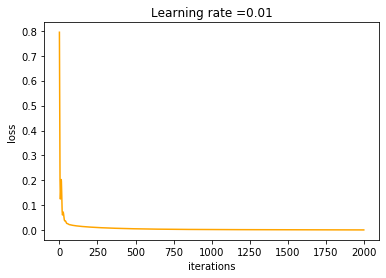

In [101]:
D_in, D_out = x_train.shape[1], y_train.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-2, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=8, activation=tanh, weights_initializer=glorot_normal))
nn.layers.append(Layer(input_dim=8, output_dim=8, activation=tanh, weights_initializer=glorot_normal))
nn.layers.append(Layer(input_dim=8, output_dim=D_out, activation=linear))

nn.fit(x_train, y_train, epochs=2000, verbose=100)

In [102]:
y_pred = nn.predict(x_test)
print('Mean squared error: {:.2f}%'.format(100*mean_squared_error(y_test, y_pred)))

Mean squared error: 0.32%


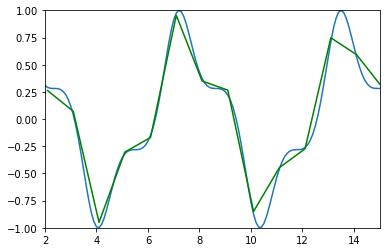

In [104]:
plt.xlim(2, 15)
plt.ylim(-1, 1)
x = np.arange(2, 100, 0.1)
y = np.sin(x + np.sin(x) ** 2)
plt.plot(x, y)
plt.plot(xplot[:,0], y_pred[:,0], color = 'green')

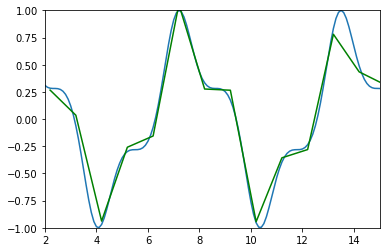

In [105]:
plt.xlim(2, 15)
plt.ylim(-1, 1)
x = np.arange(2, 100, 0.1)
y = np.sin(x + np.sin(x) ** 2)
plt.plot(x, y)
plt.plot(xplot[0:,1], y_pred[0:,1], color = 'green')

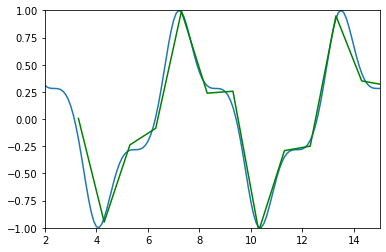

In [106]:
plt.xlim(2, 15)
plt.ylim(-1, 1)
x = np.arange(2, 100, 0.1)
y = np.sin(x + np.sin(x) ** 2)
plt.plot(x, y)
plt.plot(xplot[1:,2], y_pred[1:,2], color = 'green')

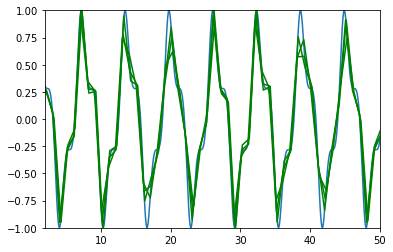

In [110]:
plt.xlim(2, 50)
plt.ylim(-1, 1)
x = np.arange(2, 100, 0.1)
y = np.sin(x + np.sin(x) ** 2)
plt.plot(x, y)
plt.plot(xplot, y_pred, color = 'green')